# Topic Modeling

En esta notebook se realiza Topic Modeling con una variedad de metodos:

1. Latent Semantic Analysis (LSA)
2. Latent Dirichlet Allocation (LDA)
1. BERTopic

In [3]:
%%capture
!pip install -r requirements.txt --user

In [1]:
import pandas as pd
import regex as re
import unidecode
import nltk
import spacy

path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

from MyModule.TopicModelingFunctinos import *
from MyModule.SentimentAnalysisFunctions import *
from MyModule.GeneralFunctions import *

In [2]:
df = pd.read_excel('../datos.xlsx')[['ID','texto','desafio']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

# Pre process and tokenization

In [10]:
%%capture
# for the preprocessing class.
!python -m spacy download es_core_news_lg 

In [4]:
pp = Preprocess()
df['prepro_text'] = pp.preprocess(df['texto'])

# Exploratory Data Analysis

In [12]:
print('Cantidad de documentos por desafio:')
df['desafio'].value_counts()

Cantidad de documentos por desafio:


13    95
15    83
16    78
12    67
14    64
17    61
18    57
Name: desafio, dtype: int64

#### A continuacion, se grafican las palabras mas frecuentes en cada desafio.

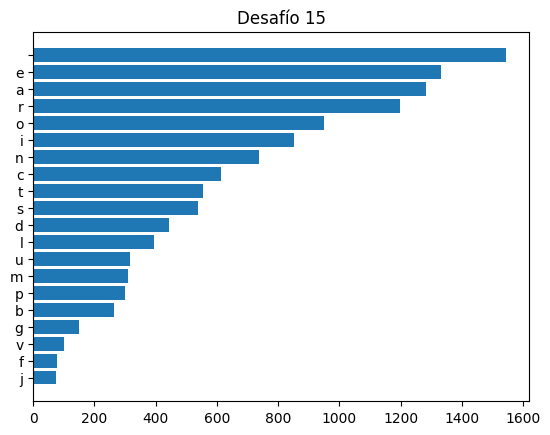

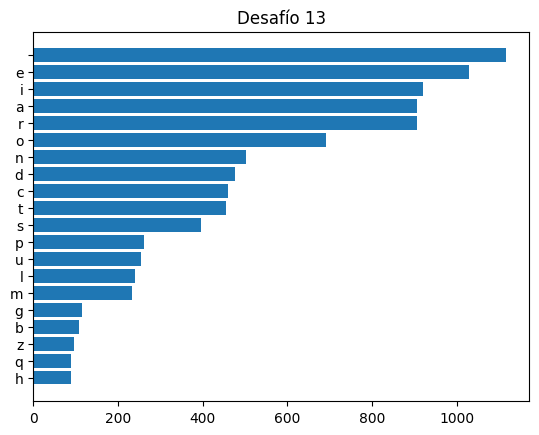

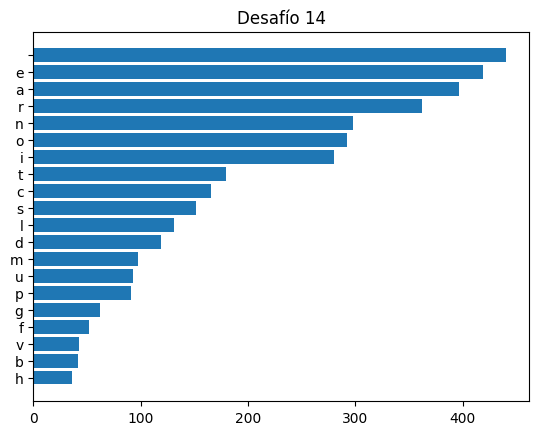

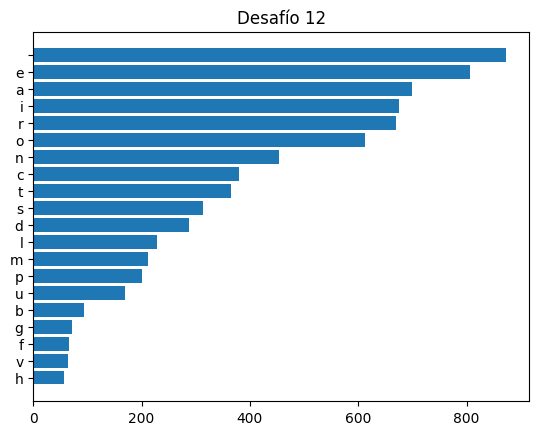

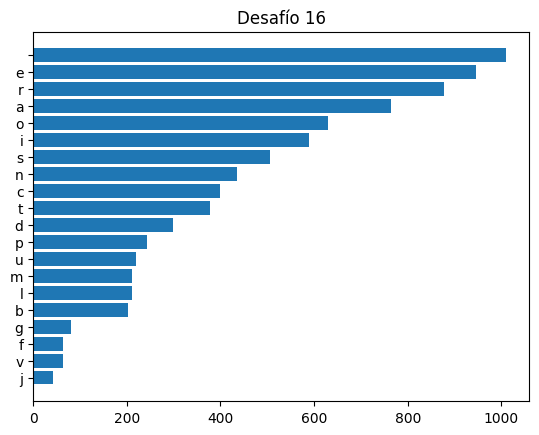

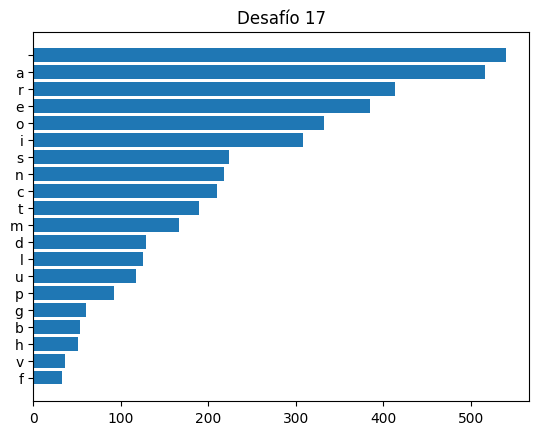

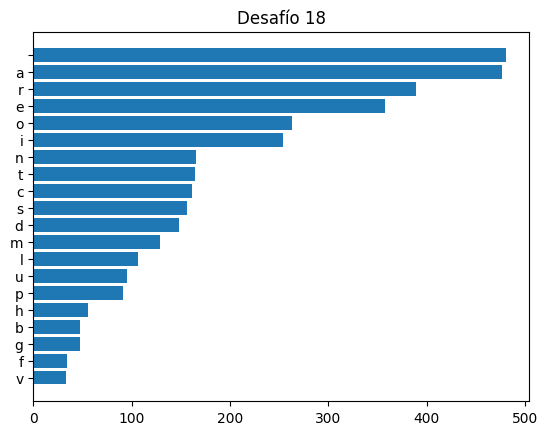

In [13]:
# Word count per desafio

desafios = df.desafio.unique()

for des in desafios:
    df_desafio = df[df['desafio']==des]
    words_desafio = df_desafio['prepro_text'].tolist()
    elements, frequencies = count_words(words_desafio)
    plot_word(elements, frequencies, plot_title = f'Desafío {des}')

#### A continuacion, se grafican la cantidad de palabras por desafio.

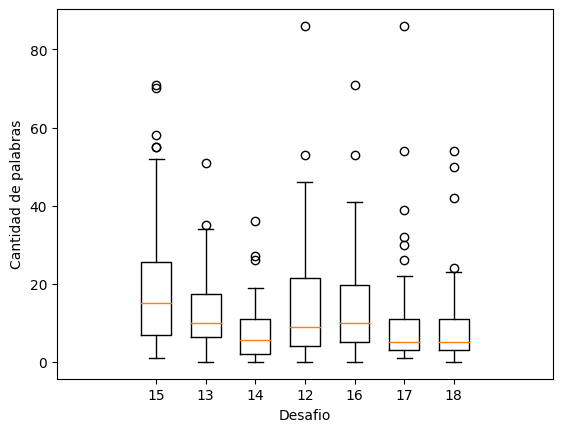

In [11]:
# Longitud de las respuestas por desafio

from matplotlib.axes import Axes
fig, ax = plt.subplots()

positions = []
for i, des in enumerate(desafios):
    df_desafio = df[df['desafio']==des]
    words_desafio = df_desafio['prepro_text'].tolist()
    len_text = [len(t) for t in df_desafio['prepro_text']]
    ax.boxplot(len_text, positions=[i/4])
    positions.append(i/4)

plt.xticks(positions, desafios)
plt.xlabel('Desafio')
plt.ylabel('Cantidad de palabras')
plt.show()

### A continuacion, se grafica el sentimiento por desafio.

- cercano a 1 = sentimiento positivo
- cercano a 0.5 = sentimiento neutro
- cercano a 0 = sentimiento negativo

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at yo

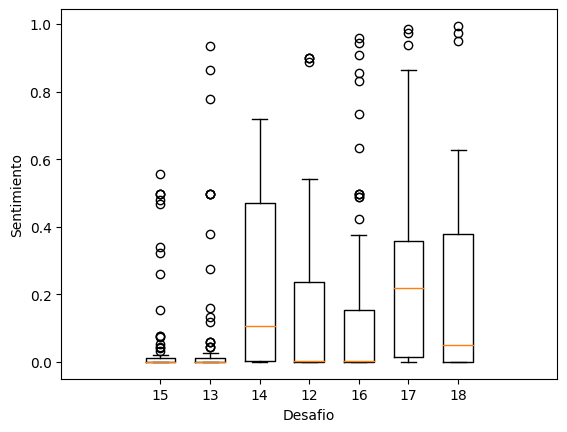

In [26]:
# Sentimiento de las respuestas por desafio

desafios = df['desafio'].unique()

fig, ax = plt.subplots() 

all_predictions = []
positions = []
for i, des in enumerate(desafios):
    df_desafio = df[df['desafio']==des]
    predictions = [analyse_sentiment_1d(t) for t in df_desafio['texto']]
    all_predictions.extend(predictions)
    ax.boxplot(predictions, positions=[i/4])
    positions.append(i/4)

plt.xticks(positions, desafios)
plt.xlabel('Desafio')
plt.ylabel('Sentimiento')
plt.show()

In [27]:
df['sentiment'] = all_predictions

### Analisis de sentimiento con Ridge Plot

In [4]:
df = pd.read_csv('../Sentiment_Analysis/sentiment_analysis_1d.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

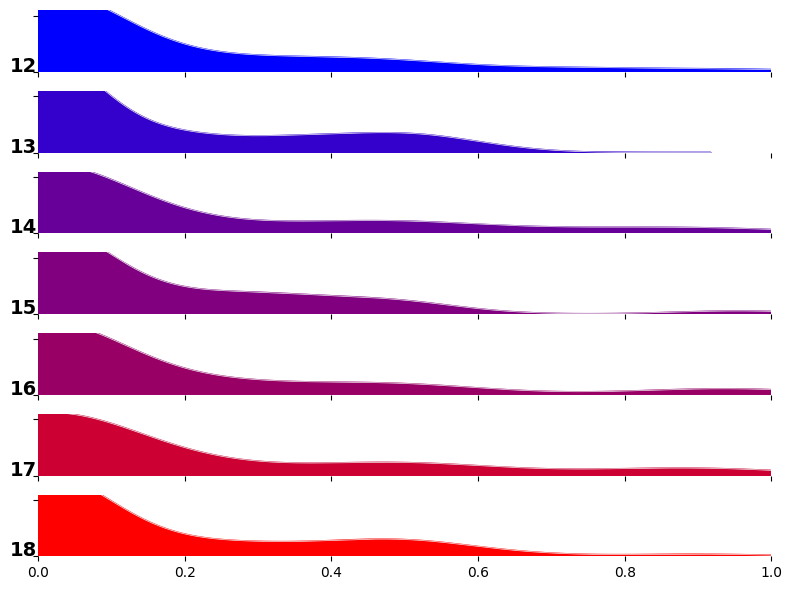

In [18]:
desafios = [x for x in np.unique(df.desafio)]
colors = ['#0000ff', '#3300cc', '#660099', '#800080', '#990066', '#cc0033', '#ff0000']

gs = (grid_spec.GridSpec(len(desafios),1))

fig = plt.figure(figsize=(8,6))

i = 0

#creating empty list
ax_objs = []

for des in desafios:
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    plot = (df[df.desafio == des]
            .sentiment.plot.kde(ax=ax_objs[-1], color="#f0f0f0", lw=0.5)
           )

    # grabbing x and y data from the kde plot
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y

    # filling the space beneath the distribution
    ax_objs[-1].fill_between(x,y,color=colors[i])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0, 1)
    ax_objs[-1].set_ylim(0,2.2)
    
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_ylabel('')

    if i != len(desafios)-1:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    # des = des.replace(" ","\n")
    ax_objs[-1].text(-0.02,0,des,fontweight="bold",fontsize=14,ha="center")

    i += 1

plt.tight_layout()
plt.show()

# Topic Modeling

## 1. Latent Semantic Analysis

In [15]:
# Define data and model

documents = df['prepro_text'].apply(lambda x: ' '.join(x))
model = TruncatedSVD

In [16]:
n_components = 4

words, wheights = words_wheights(model, documents, n_components)

A continuacion, las palabras mas importantes para cada uno de los tópicos encontrados por LSA.

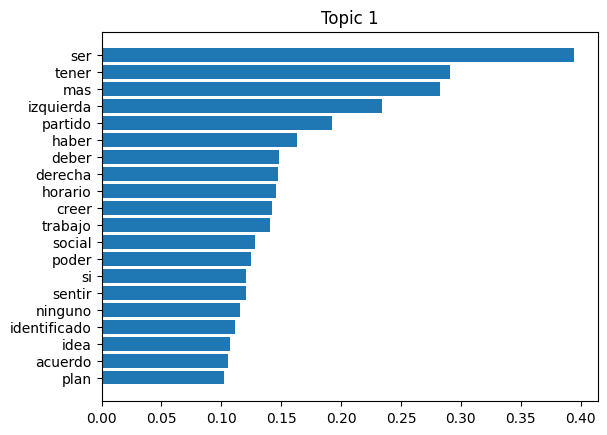

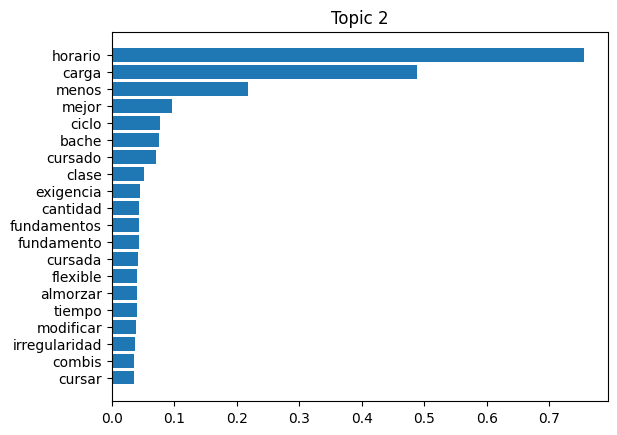

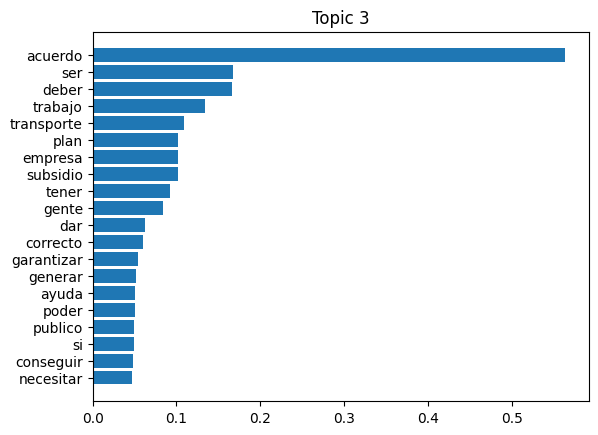

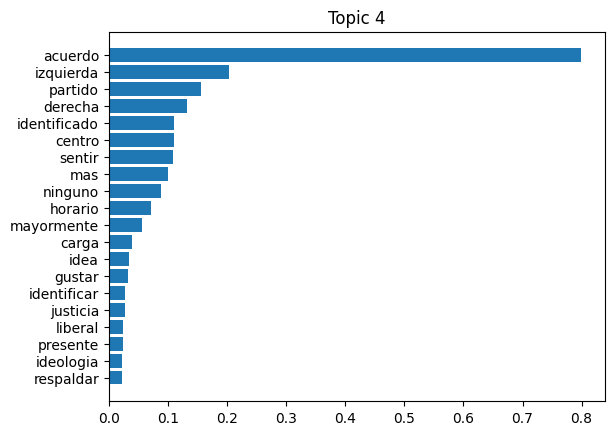

In [17]:
for i in range(n_components):
    plot_word(words[i], wheights[i], plot_title = f'Topic {i+1}')

### Evaluacion

Recordemos que la cantidad de tópicos a encontrar es un hiperparametro. Para encontrar la cantidad óptima de tópicos, podemos realizar los siguientes pasos:

1. aumentar iterativamente la cantidad de tópicos a encontrar
2. evaluar la similitud coseno promedio entre todos los pares de tópicos (cuantos mas tópicos, menor sera la similitud promedio)
3. graficar la relacion entre cantidad de tópicos y similitud entre ellos
4. decidir el numero optimo de tópicos

In [18]:
n_topics = 30

all_cs = []
for i in range(2, n_topics):
    mean_cos_simil = evaluate_coherence(model, documents, n_topics = i)
    all_cs.append(mean_cos_simil)

Podemos ver que a partir de los 5 topicos, seguir separando los textos en subtopicos no genera una ganancia significativa.

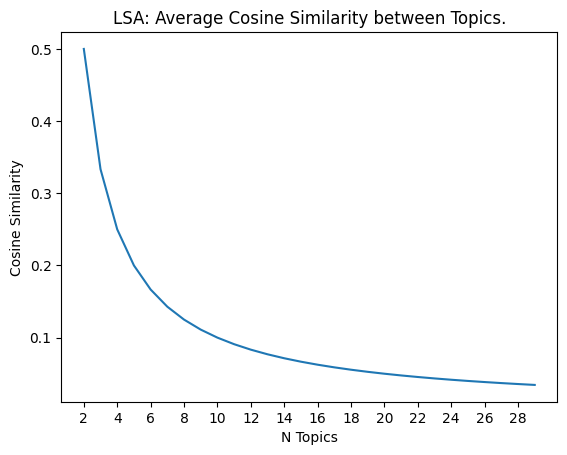

In [19]:
plt.plot(range(2, n_topics), all_cs)
plt.title('LSA: Average Cosine Similarity between Topics.')
plt.xlabel('N Topics')
plt.ylabel('Cosine Similarity')
plt.xticks(range(2, n_topics, 2), range(2, n_topics, 2))
plt.show()

Reducimos la dimensionalidad de los topicos en dos dimensiones y graficamos su distribucion

Every topic with its most relevant words.


Topic 0 = ser, tener, mas, izquierda

Topic 1 = horario, carga, menos, mejor

Topic 2 = acuerdo, ser, deber, trabajo

Topic 3 = acuerdo, izquierda, partido, derecha

Topic 4 = tener, ninguno, centro, sentir

Topic 5 = tener, clase, tiempo, mas



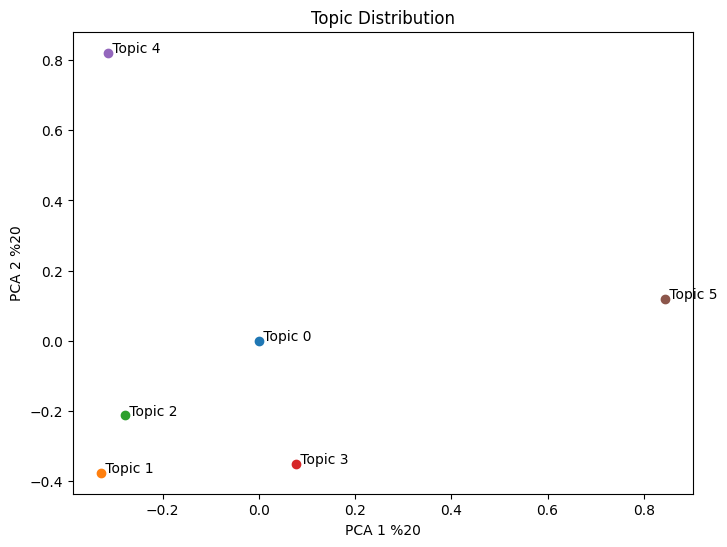

In [20]:
num_top_words = 4

visualize_topics(model, documents, num_top_words, n_components=6)

## 2. Latent Dirichlet  Allocation

In [21]:
# Define data and model

documents = df['prepro_text'].apply(lambda x: ' '.join(x))
model = LatentDirichletAllocation

In [22]:
n_components = 4

words, wheights = words_wheights(model, documents, n_components)

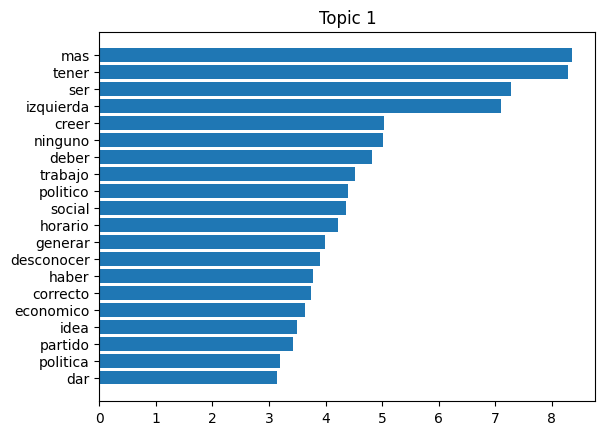

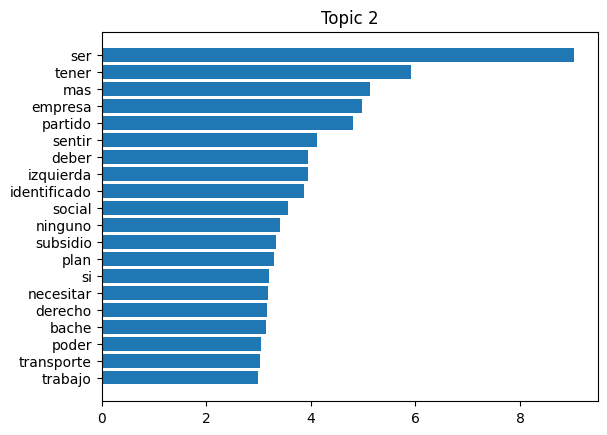

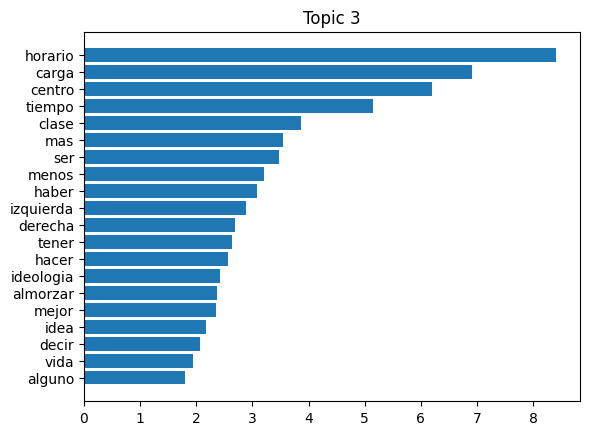

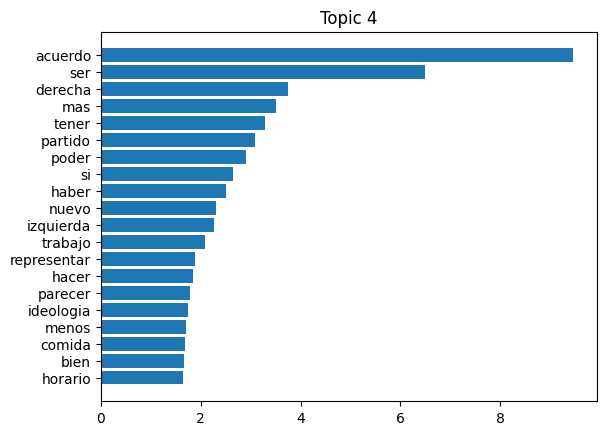

In [23]:
for i in range(n_components):
    plot_word(words[i], wheights[i], plot_title = f'Topic {i+1}')

### Evaluacion

In [24]:
n_topics = 30

all_cs = []
for i in range(2, n_topics):
    mean_cos_simil = evaluate_coherence(model, documents, n_topics = i)
    all_cs.append(mean_cos_simil)

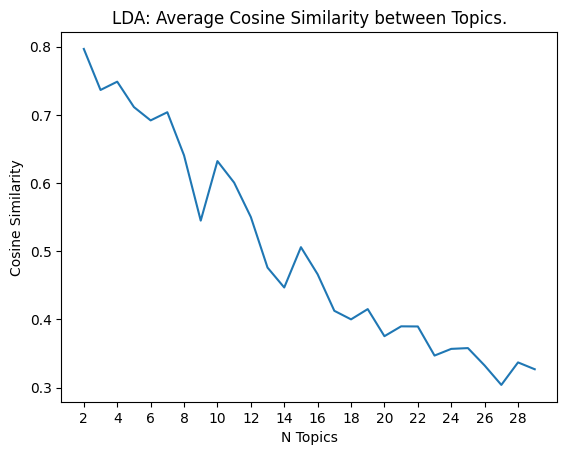

In [25]:
plt.plot(range(2, n_topics), all_cs)
plt.title('LDA: Average Cosine Similarity between Topics.')
plt.xlabel('N Topics')
plt.ylabel('Cosine Similarity')
plt.xticks(range(2, n_topics, 2), range(2, n_topics, 2))
plt.show()

Every topic with its most relevant words.


Topic 0 = ser, izquierda, partido, acuerdo

Topic 1 = ser, deber, trabajo, derecho

Topic 2 = horario, carga, ser, tiempo

Topic 3 = horario, ciclo, materia, ser

Topic 4 = mas, ser, tener, coincido

Topic 5 = tener, mas, ser, horario



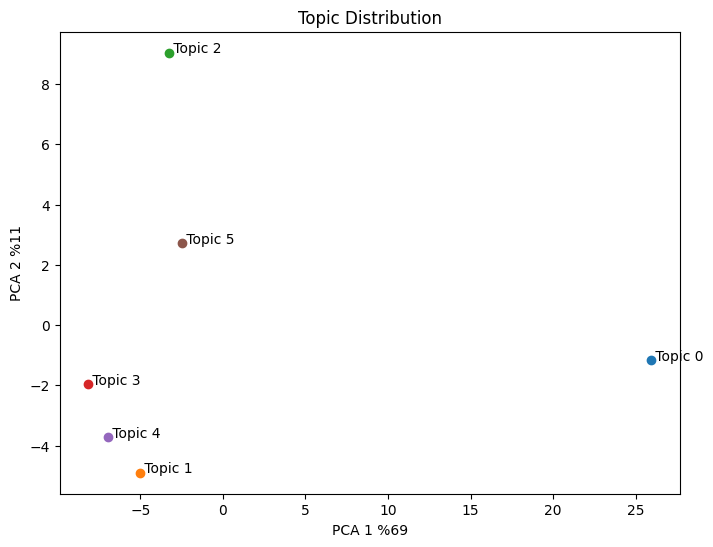

In [27]:
num_top_words = 4

visualize_topics(model, documents, num_top_words, n_components=6)

## 3. BERTopic 

- [Documentation](https://maartengr.github.io/BERTopic/api/bertopic.html)
- [Friendly Documentation](https://maartengr.github.io/BERTopic/index.html)
- [Use Case Example](https://www.pinecone.io/learn/bertopic/)

In [6]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
pp = Preprocess(lemma=False)

documents = pp.preprocess(df['texto'])
documents[:5]

['false',
 'izquierda respecta desprecio capitalismo derecha antidelincuencia',
 'dificil responder puedo pensar solo referentes cientificos deportistas',
 'posicion formada identifico liberalismo completamente liberal social relativamente economico',
 'rentabilidad empresas colectivos si creo subsidio podria ser buena idea personas realmente necesitan']

### Simple BERT model

En este caso, dejamos nr_topics="auto" para que BERT encuentre el N topicos por sí solo.

In [25]:
# Bag of Words

vectorizer_model = CountVectorizer(ngram_range=(1, 3))

model = BERTopic(
    vectorizer_model = vectorizer_model,
    language='spanish',
    calculate_probabilities=True,
    verbose=True,
    nr_topics="auto"
)

topics, probs = model.fit_transform(documents)

Batches: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
2023-02-02 11:30:47,019 - BERTopic - Transformed documents to Embeddings
2023-02-02 11:30:48,589 - BERTopic - Reduced dimensionality
2023-02-02 11:30:48,620 - BERTopic - Clustered reduced embeddings
2023-02-02 11:30:49,147 - BERTopic - Reduced number of topics from 8 to 8


#### A continuacion, la frecuencia de cada tópico.
El tópico -1 es "una bolsa de gatos" en la que BERT mete todos los docuementos que no pertenecen demasiado a ningun topico.

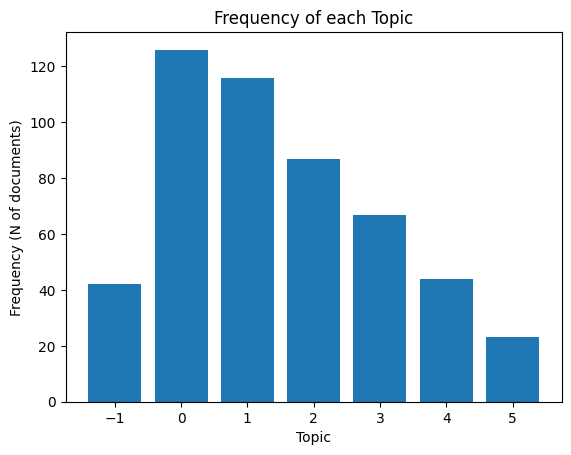

In [10]:
# Get the unique Topics and their frequencies
unique_elements, counts = np.unique(topics, return_counts=True)

plt.bar(unique_elements, counts)

# Add axis labels and a title
plt.xlabel('Topic')
plt.ylabel('Frequency (N of documents)')
plt.title('Frequency of each Topic')
plt.show()

#### El siguiente mapa interactivo muestra la distribucion de los topicos encontrados.

El tamaño de cada circulo representa la cantidad de documentos que contiene.

In [11]:
model.visualize_topics()

#### Las palabras mas representativas de cada topico.

In [26]:
model.visualize_barchart(top_n_topics=len(model.get_topics()))

### A continuacion, se imprimen los documentos mas representativos para cada topico

In [29]:
original_texts = df['texto'].values.tolist()
prepro_texts = df['prepro_text'].values.tolist()

for key, value in model.get_representative_docs().items():
    print('\n'*4),print(f'TOPIC {key} most representative documents:\n')
    for i, doc in enumerate(value):
        indice = documents.index(doc)
        print(f'{i+1}.\n {original_texts[indice]}\n\n')






TOPIC 2 most representative documents:

1.
 .


2.
 .


3.
 .







TOPIC 0 most representative documents:

1.
 Nueva izquierda independiente. Porque mantenemos muchas de las banderas históricas de la "izquierda tradicional" pero alejada de los partidos burocráticos y las practicas personalistas. 


2.
 Socialismo, partidos de izquierda... aunque muchas veces las acciones y decisiones de estos sectores no me representan porque actúan en base a intereses personales.. Hoy el sector que más representa mis intereses es el peronismo/kirchnerismo. 


3.
 Me siento identificado un poco más a partidos de izquierda, pero básicamente prefiero partidos de centro. Creo que las categorías izquierda-derecha, si bien representan algunos lineamientos generales de la población, tienden a tergiversar la interpretación de la realidad y generar falsas controversias que nos alejan de soluciones pragmáticas que promuevan mejoras en el bienestar colectivo.







TOPIC 4 most representative documents:


### More complex BERT model

Se ayuda de embeddings de palabras pre entrenados (para captar mejor el significado), UMAP (para reducir dimensiones) y HDBSCAN (para clustering).

Ademas, se puede experimentar con nr_topics. En este caso, lo dejamos en 7 para compararlo con el BERT sencillo.

In [14]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('bert-base-nli-mean-tokens') # embedings pre entrenado en español
umap_model = UMAP(n_neighbors=3, n_components=3)
hdbscan_model = HDBSCAN(gen_min_span_tree=True, prediction_data=True)

# Bag of words
vectorizer_model = CountVectorizer(ngram_range=(1, 3))

In [15]:
model = BERTopic(
    umap_model = umap_model,
    hdbscan_model = hdbscan_model,
    embedding_model = embedding_model,
    vectorizer_model = vectorizer_model,
    top_n_words=5,
    language='spanish',
    calculate_probabilities=True,
    verbose=True,
    nr_topics="auto"
)
topics, probs = model.fit_transform(documents)

Batches: 100%|██████████| 16/16 [00:28<00:00,  1.75s/it]
2023-02-02 11:14:15,204 - BERTopic - Transformed documents to Embeddings
2023-02-02 11:14:17,108 - BERTopic - Reduced dimensionality
2023-02-02 11:14:17,164 - BERTopic - Clustered reduced embeddings
2023-02-02 11:14:20,109 - BERTopic - Reduced number of topics from 25 to 25


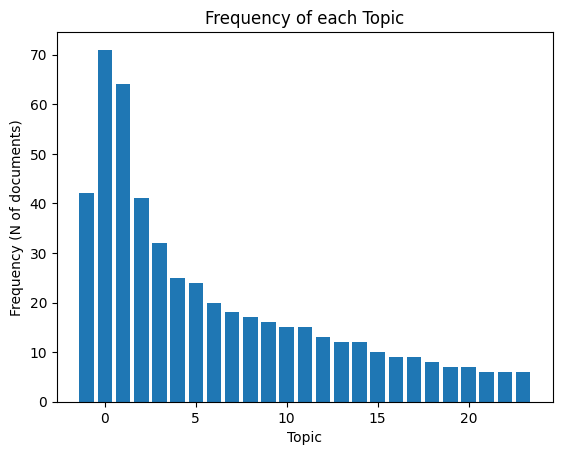

In [16]:
# Get the unique Topics and their frequencies
unique_elements, counts = np.unique(topics, return_counts=True)

plt.bar(unique_elements, counts)

# Add axis labels and a title
plt.xlabel('Topic')
plt.ylabel('Frequency (N of documents)')
plt.title('Frequency of each Topic')
plt.show()

In [17]:
model.visualize_topics()

In [18]:
model.visualize_barchart()

#### A continuacion, se imprimen los documentos mas representativos de cada topico.

In [24]:
original_texts = df['texto'].values.tolist()
prepro_texts = df['prepro_text'].values.tolist()

for key, value in model.get_representative_docs().items():
    print('\n'),print(f'TOPIC {key} most representative documents:\n')
    for i, doc in enumerate(value):
        indice = documents.index(doc)
        print(f'{i+1}.\n {original_texts[indice]}\n\n')



TOPIC 0 most representative documents:

1.
 De centro.


2.
 Nelson Castro. Por su claridad, calidad profesional 


3.
 Grabois




TOPIC 3 most representative documents:

1.
 Más de izquierda, por sus ideas y propuestas y conceptos en relación a la situación económica y social. 


2.
 A Arturo Frondizi por el gran movimiento económico que generó en su gobierno


3.
 San Martin ..Toda su obra .. desde lo tactico ..lo tecnico .. lo estrategico .su humildad su grandeza .lo economico   ( ver su gestion como gob de cuyo) .. admirado mundialmenre por sus hazañas y proezas y en el momento mas culmine de su carrera .. opto por se solo abuelo de sus nietas hasta el fin de sus dias 




TOPIC 20 most representative documents:

1.
 De Izquierda pensando en igualar 


2.
 Dudo cuan dificil es conseguir trabajo 


3.
 De izquierda. Porque me preocupa la calidad de vida de toda la población 




TOPIC 17 most representative documents:

1.
 Últimamente me siento mas identificado con partidos de de

#### Podemos ver como se clusterizan los documentos.

In [40]:
model.visualize_documents(documents, hide_annotations=True)

#### Tambien podemos ver la correlacion entre los topicos.

In [41]:
model.visualize_heatmap()

## Metodos relevantes

#### Se puede predecir la categoria de una lista de documentos.

In [42]:
textos_nuevos = ['las empresas de trasporte']

predicted_cat, probs_dis = model.transform(textos_nuevos)

for i in range(len(predicted_cat)):
    print(f'Example {i}:\n')
    print(f'Predicted Topic: {predicted_cat[i]}\n')
    print(f'Predicted Prob: {probs_dis[i][0]}')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-12-21 11:38:44,898 - BERTopic - Reduced dimensionality
2022-12-21 11:38:44,902 - BERTopic - Calculated probabilities with HDBSCAN
2022-12-21 11:38:44,902 - BERTopic - Predicted clusters


Example 0:

Predicted Topic: -1

Predicted Prob: 0.09134030538885717
